# **Deep Q-Learning (Traditional)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os

In [ ]:
if not os.path.exists('Analysis/'):
  os.makedirs('Analysis/')
SAVE_DIR = 'Analysis/'

In [ ]:
environment_rows = 6
environment_columns = 6

In [ ]:
actions = ['up', 'right', 'down', 'left']
rewards = np.full((6, 6), -100)

aisles = {}
aisles[1] = [i for i in range(1, 5)]
aisles[2] = [2, 3, 4]
aisles[3] = [3, 4]
aisles[4] = [1, 2, 3]
for row_index in range(1, 5):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1
rewards[1, 1] = 100
for row in rewards:
  print(row)

[-100 -100 -100 -100 -100 -100]
[-100  100   -1   -1   -1 -100]
[-100 -100   -1   -1   -1 -100]
[-100 -100 -100   -1   -1 -100]
[-100   -1   -1   -1 -100 -100]
[-100 -100 -100 -100 -100 -100]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
        self.epsilon = 1.0  # Initial value for epsilon
        self.epsilon_decay = 0.999  # Decay rate for epsilon
        self.min_epsilon = 0.1  # Minimum value for epsilon

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in batch])
        if(self.epsilon>=self.min_epsilon):
          self.epsilon = self.epsilon * self.epsilon_decay
        return states, actions, rewards, next_states, dones

In [ ]:
def is_terminal_state(current_row_index, current_column_index):
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

def get_starting_location():
  current_row_index = np.random.randint(4)
  current_column_index = np.random.randint(4)
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index


def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

def get_next_action(state, epsilon):
    if np.random.random() > epsilon:
        q_values = q_network(torch.tensor(state).float())
        action_index = torch.argmax(q_values).item()
    else:
        action_index = np.random.randint(len(actions))
    return action_index

def update_network():
    if len(replay_buffer.buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    states = torch.tensor(states).float()
    actions = torch.tensor(actions).unsqueeze(1)
    rewards = torch.tensor(rewards).unsqueeze(1)
    next_states = torch.tensor(next_states).float()
    dones = torch.tensor(dones).unsqueeze(1)


    current_q_values = q_network(states).gather(1, actions)
    next_q_values = target_network(next_states).max(1)[0].unsqueeze(1)
    target_q_values = rewards + (discount_factor * next_q_values) - current_q_values

    loss = nn.MSELoss()(current_q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Episode 1: Total Reward = -101
Episode 1: Epsilon = 1.0
Episode 2: Total Reward = -100
Episode 2: Epsilon = 1.0
Episode 3: Total Reward = 97
Episode 3: Epsilon = 1.0
Episode 4: Total Reward = -100
Episode 4: Epsilon = 1.0
Episode 5: Total Reward = -100
Episode 5: Epsilon = 1.0
Episode 6: Total Reward = -102
Episode 6: Epsilon = 1.0
Episode 7: Total Reward = -104
Episode 7: Epsilon = 1.0
Episode 8: Total Reward = -105
Episode 8: Epsilon = 1.0
Episode 9: Total Reward = -102
Episode 9: Epsilon = 1.0
Episode 10: Total Reward = -102
Episode 10: Epsilon = 1.0
Episode 11: Total Reward = -101
Episode 11: Epsilon = 1.0
Episode 12: Total Reward = -101
Episode 12: Epsilon = 0.998001
Episode 13: Total Reward = -103
Episode 13: Epsilon = 0.994014980014994
Episode 14: Total Reward = -103
Episode 14: Epsilon = 0.9900448802097482
Episode 15: Total Reward = 96
Episode 15: Epsilon = 0.9851045463620021
Episode 16: Total Reward = -103
Episode 16: Epsilon = 0.9811700348643991
Episode 17: Total Reward = -10

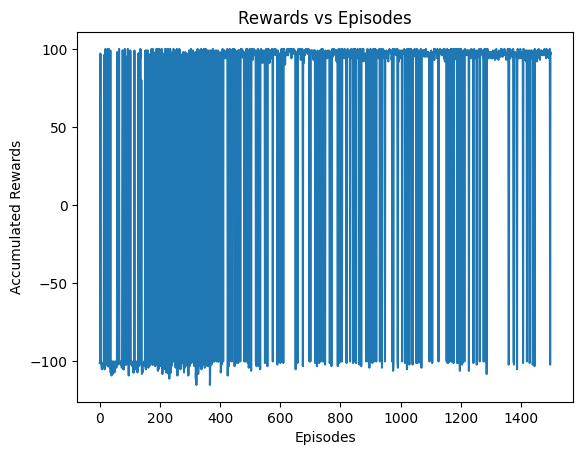

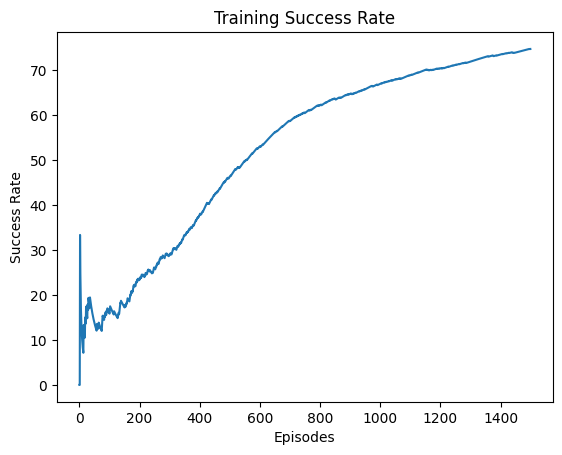

In [ ]:
q_network = QNetwork(2, len(actions))
target_network = QNetwork(2, len(actions))
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=0.003)
buffer_size = 1000
replay_buffer = ReplayBuffer(buffer_size)
#epsilon = 0.9
discount_factor = 0.99
batch_size = 32
total_reward_record = []
success_rates = []
PATHS = []
action_temp = []
episode_number = []
eps = []
def train_agent(num_episodes):
    successful_episodes = 0
    for episode in range(num_episodes):
        path = []
        episode_number.append(episode)
        row_index, column_index = get_starting_location()
        #state = get_state(row_index, column_index)
        state = [row_index, column_index]
        path.append([state,None])
        #print(state)
        done = False
        total_reward = 0


        while not done:
            action_index = get_next_action(state, replay_buffer.epsilon)

            next_row_index, next_column_index = get_next_location(row_index, column_index, action_index)
            reward = rewards[next_row_index, next_column_index]
            #next_state = get_state(next_row_index, next_column_index)
            next_state = [next_row_index, next_column_index]
            done = is_terminal_state(next_row_index, next_column_index)
            path.append([next_state, action_index])
            action_temp.append(action_index)
            replay_buffer.add(state, action_index, reward, next_state, done)
            update_network()

            total_reward += reward
            state = next_state
            row_index = next_row_index
            column_index = next_column_index
            if reward == 100:
              successful_episodes += 1
        success_rate = successful_episodes/(episode+1)
        success_rates.append(success_rate*100)
        PATHS.append(path)

        if (episode + 1) % 100 == 0:
            target_network.load_state_dict(q_network.state_dict())

        print(f"Episode {episode + 1}: Total Reward = {total_reward}")
        print(f"Episode {episode + 1}: Epsilon = {replay_buffer.epsilon}")
        # print(path)
        # print(action_temp)
        total_reward_record.append(total_reward)
        eps.append(replay_buffer.epsilon)

    print('Training complete!')
    print("Success Rate:",success_rates[episode])

    log_frame = pd.DataFrame(columns = ["Episodes", "Rewards", "Epsilon", "Path"])
    log_frame["Episodes"] = episode_number
    log_frame["Rewards"] =  total_reward_record
    log_frame["Path"] = PATHS
    log_frame["Epsilon"] = eps
    log_frame.to_csv(os.path.join('./Analysis/', "NO_subtract.csv"), index = False)

# Train the agent
train_agent(1500)

plt.figure(1)
plt.plot(total_reward_record)
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
plt.title('Rewards vs Episodes')

plt.figure(2)
plt.plot(success_rates)
plt.xlabel('Episodes')
plt.ylabel('Success Rate')
plt.title('Training Success Rate')

plt.show()

Text(0.5, 1.0, 'Rewards vs Episodes')

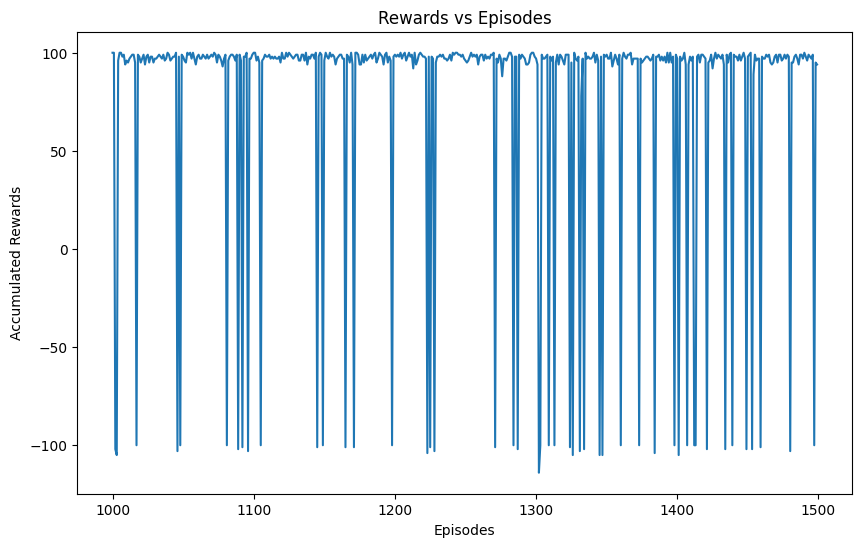

In [ ]:
fig = plt.figure(figsize = (10,6))
plt.plot(np.arange(1000, 1500), total_reward_record[1000:1500])
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
plt.title('Rewards vs Episodes')

In [ ]:
model_path = "q_network_model.pth"
torch.save(q_network.state_dict(), model_path)

In [ ]:
model_path = "q_network_model.pth"
q_network = QNetwork(2, len(actions))
q_network.load_state_dict(torch.load(model_path))

In [ ]:
def test_agent():
  test_successful_episode = 0
  test_episodes = 100
  for i in range(test_episodes):
    row_index, column_index = get_starting_location()

    #row_index, column_index = 2, 4
    state = [row_index, column_index]
    done = False
    path = []
    action_temp = []
    path.append(state)

    while not done:
        action_index = get_next_action(state, epsilon=0)
        next_row_index, next_column_index = get_next_location(row_index, column_index, action_index)
        path.append([next_row_index, next_column_index])
        action_temp.append(action_index)
        done = is_terminal_state(next_row_index, next_column_index)
        state = [next_row_index, next_column_index]
        row_index = next_row_index
        column_index = next_column_index
    if path[-1] == [1, 1]:
      test_successful_episode += 1
    print(path)
  test_success_rate =  ((test_successful_episode)/(test_episodes))
  test_success_rate = test_success_rate*100
  print("Success Count: ", test_successful_episode)
  print("Success Rate: ", test_success_rate)

test_agent()

[[1, 3], [1, 2], [1, 1]]
[[1, 3], [1, 2], [1, 1]]
[[3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[2, 4], [2, 3], [2, 2], [1, 2], [1, 1]]
[[3, 4], [2, 4], [2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[4, 1], [4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[3, 4], [2, 4], [2, 3], [2, 2], [1, 2], [1, 1]]
[[3, 4], [2, 4], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 1], [4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 2], [1, 1]]
[[4, 1], [4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 2], [1, 1]]
[[1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[2, 4], [2, 3], [2, 2], [1, 2], [1, 

# **Deep Q-Learning (Federated Learning)**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import copy

environment_rows = 6
environment_columns = 6

actions = ['up', 'right', 'down', 'left']
rewards = np.full((6, 6), -100)

aisles = {}
aisles[1] = [i for i in range(1, 5)]
aisles[2] = [2, 3, 4]
aisles[3] = [3, 4]
aisles[4] = [1, 2, 3]

for row_index in range(1, 5):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1
rewards[1, 1] = 100
for row in rewards:
  print(row)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
        self.epsilon = 1.0  # Initial value for epsilon
        self.epsilon_decay = 0.999  # Decay rate for epsilon
        self.min_epsilon = 0.1  # Minimum value for epsilon

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in batch])
        if(self.epsilon>=self.min_epsilon):
          self.epsilon = self.epsilon * self.epsilon_decay
        return states, actions, rewards, next_states, dones

def is_terminal_state(current_row_index, current_column_index):
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

def get_starting_location():
  current_row_index = np.random.randint(6)
  current_column_index = np.random.randint(6)
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

def get_next_action(state, epsilon):
    if np.random.random() > epsilon:
        q_values = q_network(torch.tensor(state).float())
        action_index = torch.argmax(q_values).item()
    else:
        action_index = np.random.randint(len(actions))
    return action_index

q_network = QNetwork(2, len(actions))
target_network = QNetwork(2, len(actions))
target_network.load_state_dict(q_network.state_dict())
optimizer = optim.Adam(q_network.parameters(), lr=0.001)
buffer_size = 1000
replay_buffer = ReplayBuffer(buffer_size)
discount_factor = 0.9
batch_size = 32
PATHS = []
action_temp = []
episode_number = []
eps = []

num_clients = 2
client_models = [copy.deepcopy(q_network) for _ in range(num_clients)]
client_optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in client_models]
client_replay_buffers = [ReplayBuffer(buffer_size) for _ in range(num_clients)]

def federated_averaging(models):
    num_models = len(models)
    averaged_state_dict = {}
    for param_name in models[0].state_dict():
        param_sum = torch.zeros_like(models[0].state_dict()[param_name])
        for model in models:
            param_sum += model.state_dict()[param_name]
        averaged_state_dict[param_name] = param_sum / num_models
    return averaged_state_dict

def update_network(client_index):
    if len(client_replay_buffers[client_index].buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = client_replay_buffers[client_index].sample(batch_size)
    states = torch.tensor(states).float()
    actions = torch.tensor(actions).unsqueeze(1)
    rewards = torch.tensor(rewards).unsqueeze(1)
    next_states = torch.tensor(next_states).float()
    dones = torch.tensor(dones).unsqueeze(1)
    current_q_values = client_models[client_index](states).gather(1, actions)
    next_q_values = target_network(next_states).max(1)[0].unsqueeze(1)
    target_q_values = rewards + (discount_factor * next_q_values)
    loss = nn.MSELoss()(current_q_values, target_q_values)
    client_optimizers[client_index].zero_grad()
    loss.backward()
    client_optimizers[client_index].step()

num_communication_rounds = 10
total_reward_client = []
total_reward_record = [total_reward_client, total_reward_client]
success_rates_client_1 = []
success_rates_client_2 = []

def federated_train_agent(num_episodes, num_local_epochs):
    successful_episodes = [0] * num_clients
    for communication_round in range(num_communication_rounds):
        for episode in range(num_episodes):
            paths = [[] for _ in range(num_clients)]
            episode_number.append(episode)
            for client_index in range(num_clients):
                row_index, column_index = get_starting_location()
                state = [row_index, column_index]
                paths[client_index].append([state,None])
                done = False
                total_reward = 0
                while not done:
                    action_index = get_next_action(state, client_replay_buffers[client_index].epsilon)

                    next_row_index, next_column_index = get_next_location(row_index, column_index, action_index)
                    reward = rewards[next_row_index, next_column_index]
                    next_state = [next_row_index, next_column_index]
                    done = is_terminal_state(next_row_index, next_column_index)
                    paths[client_index].append([next_state, action_index])
                    action_temp.append(action_index)
                    client_replay_buffers[client_index].add(state, action_index, reward, next_state, done)

                    total_reward += reward
                    state = next_state
                    row_index = next_row_index
                    column_index = next_column_index
                    if reward == 100:
                        successful_episodes[client_index] += 1
            total_reward_record[client_index].append(total_reward)

            for client_index in range(num_clients):
              for _ in range(num_local_epochs):
                update_network(client_index)

            averaged_state_dict = federated_averaging(client_models)
            target_network.load_state_dict(averaged_state_dict)
            PATHS.append(paths)

            if (episode + 1) % 100 == 0:
                target_network.load_state_dict(averaged_state_dict)

            print(f"Communication Round {communication_round+1} - Episode {episode + 1}: Total Reward = {total_reward}")
            #print(f"Communication Round {communication_round+1} - Episode {episode + 1}: Epsilon = {client_replay_buffers[0].epsilon}")

    print('Training complete!')


# Perform federated training
federated_train_agent(1500, 1)

Streaming output truncated to the last 5000 lines.
Communication Round 7 - Episode 1002: Total Reward = -101
Communication Round 7 - Episode 1003: Total Reward = 99
Communication Round 7 - Episode 1004: Total Reward = -101
Communication Round 7 - Episode 1005: Total Reward = -101
Communication Round 7 - Episode 1006: Total Reward = -103
Communication Round 7 - Episode 1007: Total Reward = -101
Communication Round 7 - Episode 1008: Total Reward = -101
Communication Round 7 - Episode 1009: Total Reward = -102
Communication Round 7 - Episode 1010: Total Reward = -100
Communication Round 7 - Episode 1011: Total Reward = -101
Communication Round 7 - Episode 1012: Total Reward = -100
Communication Round 7 - Episode 1013: Total Reward = 100
Communication Round 7 - Episode 1014: Total Reward = -100
Communication Round 7 - Episode 1015: Total Reward = 98
Communication Round 7 - Episode 1016: Total Reward = -102
Communication Round 7 - Episode 1017: Total Reward = -100
Communication Round 7 - Ep

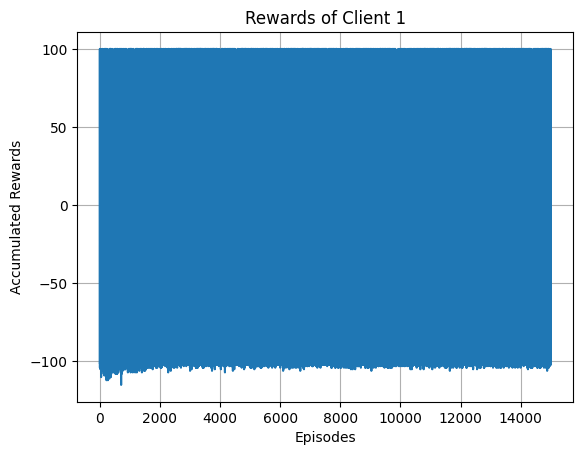

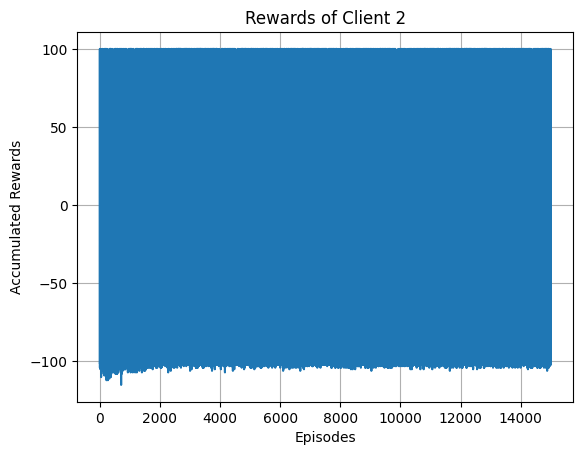

In [ ]:
plt.figure(1)
plt.plot(total_reward_record[0])
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
plt.title('Rewards of Client 1')
plt.grid()

plt.figure(2)
plt.plot(total_reward_record[1])
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
plt.title('Rewards of Client 2')
plt.grid()

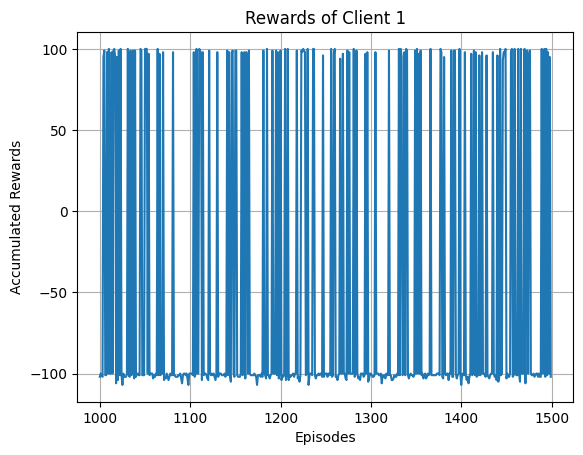

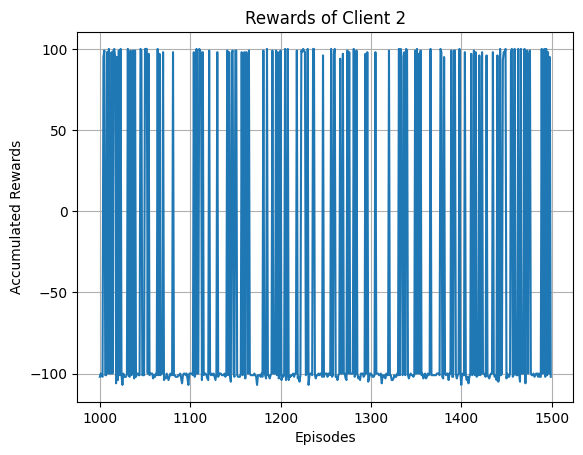

In [ ]:
plt.figure(1)
plt.plot(np.arange(1000, 1500), total_reward_record[0][1000:1500])
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
plt.title('Rewards of Client 1')
plt.grid()

plt.figure(2)
plt.plot(np.arange(1000, 1500), total_reward_record[1][1000:1500])
plt.xlabel('Episodes')
plt.ylabel('Accumulated Rewards')
plt.title('Rewards of Client 2')
plt.grid()

plt.show()

[[1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 1], [4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[1, 3], [1, 2], [1, 1]]
[[1, 3], [1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 1], [4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 1], [4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[1, 3], [1, 2], [1, 1]]
[[4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 2], [4, 3], [3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[1, 2], [1, 1]]
[[3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[2, 2], [1, 2], [1, 1]]
[[1, 4], [1, 3], [1, 2], [1, 1]]
[[3, 3], [2, 3], [2, 2], [1, 2], [1, 1]]
[[4, 3], [3, 3], [2, 3], [2, 2

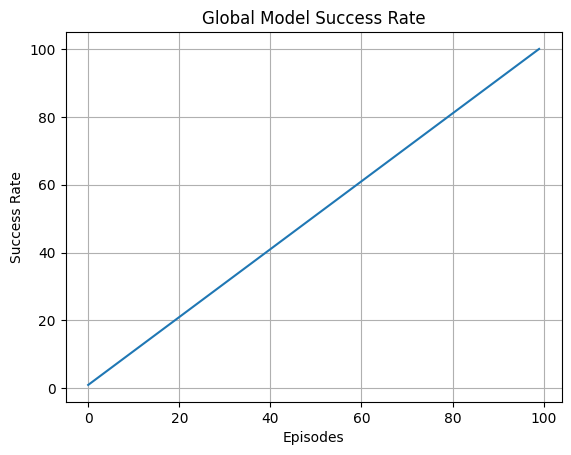

In [ ]:
def test_agent():
  test_successful_episode = 0
  test_episodes = 100
  succe = []
  for i in range(test_episodes):
    row_index, column_index = get_starting_location()

    #row_index, column_index = 2, 4
    state = [row_index, column_index]
    done = False
    path = []
    action_temp = []
    path.append(state)

    while not done:
        q_values = target_network(torch.tensor(state).float())
        action_index = torch.argmax(q_values).item()
        next_row_index, next_column_index = get_next_location(row_index, column_index, action_index)
        path.append([next_row_index, next_column_index])
        action_temp.append(action_index)
        done = is_terminal_state(next_row_index, next_column_index)
        state = [next_row_index, next_column_index]
        row_index = next_row_index
        column_index = next_column_index
    if path[-1] == [1, 1]:
      test_successful_episode += 1
    print(path)
    test_success_rate =  ((test_successful_episode)/(test_episodes))
    test_success_rate = test_success_rate*100
    succe.append(test_success_rate)
  print("Success Count: ", test_successful_episode)
  print("Success Rate: ", test_success_rate)
  plt.plot(succe)
  plt.xlabel('Episodes')
  plt.ylabel('Success Rate')
  plt.title('Global Model Success Rate')
  plt.grid()


test_agent()